<a href="https://colab.research.google.com/github/reshalfahsi/neuralnetwork/blob/main/notebook/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Install Package**

In [1]:
!cd /content
!git clone -q https://github.com/reshalfahsi/neuralnetwork
%cd neuralnetwork
!pip install -q .

/content/neuralnetwork
  Preparing metadata (setup.py) ... done


## **Hyperparameters**

In [2]:
NUM_EPOCHS = 32
BATCH_SIZE = 16
lr = 1e-2

## **Dataset Preparation**

This tutorial will use a regression problem dataset from [Medical Insurance Cost](https://www.kaggle.com/datasets/gauravduttakiit/medical-insurance-cost?select=Train_Data.csv). This dataset was inspired by the book *Machine Learning with R by Brett Lantz*. The data contains medical information and costs billed by health insurance companies. It contains 3630 rows of data and the following columns: `age`, `gender`, `BMI`, `children`, `smoker`, `region` and `charges`.

In [3]:
from neuralnetwork.ds.medical_insurance_cost import MedicalInsuranceCost
from neuralnetwork import ds
import numpy as np


train_dataset = MedicalInsuranceCost(split='train')
test_dataset = MedicalInsuranceCost(split='test')

print("Train Dataset:", len(train_dataset))
print("Test Dataset", len(test_dataset))

Train Dataset: 3300
Test Dataset 330


In [4]:
train_dataset.head(n=10)

        age     sex       bmi  smoker     region  children   charges
0 -1.472059    male -0.897698       0  northeast         2 -0.884496
1 -0.157193  female -0.897852       1  southeast         3  0.806770
2 -1.718952    male -0.110204       0  southeast         1 -1.029619
3 -0.155298    male  0.008682       0  northeast         3 -0.556791
4  1.572950    male  0.253679       0  southeast         1 -0.077998
5  0.585379    male -0.736891       0  southeast         1 -0.469256
6 -1.124621    male  0.103467       0  northeast         4  0.832997
7 -0.773646  female -1.177481       0  northwest         2 -0.732155
8 -1.017736    male -1.022537       0  southwest         5 -0.676427
9  0.708289  female -0.611551       0  northwest         3  0.393119


## **Neural Network**

The artificial neural network is a bio-inspired machine learning method that models neuronal signal propagation by matrix multiplication. Here we have two kinds of neuronal signal propagation: forward propagation and backward propagation. In forward propagation, the neuron actively conveys information from the "receptor" (or input) to the "central nervous system" (or output). Backward propagation or backpropagation, in short, is utilized in the training or learning process. In the learning process, the neural network transmits error gradients from the "central nervous system" to the "receptor". For further knowledge about the learning process, read more: [Calculus on Computational Graphs: Backpropagation](https://colah.github.io/posts/2015-08-Backprop/) and [Backpropagation for a Linear Layer
](https://web.eecs.umich.edu/~justincj/teaching/eecs442/notes/linear-backprop.html).

In [5]:
import neuralnetwork.nn as nn


class NeuralNetwork(nn.Module):
    def __init__(self, **kwargs):
        super(NeuralNetwork, self).__init__(**kwargs)
        self.linear0 = nn.Linear(3, 300, **kwargs)
        self.linear1 = nn.Linear(300, 30, **kwargs)
        self.linear2 = nn.Linear(30, 1, **kwargs)

        self.activation = nn.Tanh()

    def forward(self, x):
        self.out0 = self.linear0(x)
        self.out1 = self.activation(self.out0)
        self.out2 = self.linear1(self.out1)
        self.out3 = self.activation(self.out2)
        self.out4 = self.linear2(self.out3)
        self.out5 = self.activation(self.out4)

        return self.out5
    
    def backward(self, lr, criterion, method=None):
                                                               # Computational Graph
                                                               #
        self.dx0 = criterion.grad()                            # loss_grad(pred, y)
                                                               #        |
        self.dx1 = self.activation.grad(self.out4)             # tanh_grad(pred)
                                                               #        |
                                                               #        +
                                                               #       / \
                                                               #      |   |
                                                               #  b_grad  *
                                                               #         / \
                                                               #        |   |
        self.dx2 = self.linear2.grad(self.dx1 * self.dx0)      #   A_grad   x_grad
                                                               #          .
        self.dx3 = self.activation.grad(self.out2)             #          .
        self.dx4 = self.linear1.grad(self.dx3 * self.dx2)      #          .

        self.dx5 = self.activation.grad(self.out0)
        self.dx6 = self.linear0.grad(self.dx5 * self.dx4)

        if method == 'newton':
            self.d2x0 = criterion.grad('hessian')                                                        
            self.d2x1 = self.activation.grad(self.out4, 'hessian')

            gradient = {
                'error_first': self.dx0,
                'error_second': self.d2x0,
                'nonlinearity_first': self.dx1,
                'nonlinearity_second': self.d2x1,
            }               

            self.d2x2 = self.linear2.grad(gradient, 'hessian')
            self.d2x3 = self.activation.grad(self.out2, 'hessian') 

            gradient = {
                'error_first': self.dx2,
                'error_second': self.d2x2,
                'nonlinearity_first': self.dx3,
                'nonlinearity_second': self.d2x3,
            }         
                                                                            
            self.d2x4 = self.linear1.grad(gradient, 'hessian')
            self.d2x5 = self.activation.grad(self.out0, 'hessian')

            gradient = {
                'error_first': self.dx4,
                'error_second': self.d2x4,
                'nonlinearity_first': self.dx5,
                'nonlinearity_second': self.d2x5,
            } 

            self.d2x6 = self.linear0.grad(gradient, 'hessian')

        self.linear0.update(lr, method)
        self.linear1.update(lr, method)
        self.linear2.update(lr, method)

## **Utilities**

In [6]:
import time
import matplotlib.pyplot as plt

seed = np.random.randint(2147483647)
print(seed)

1111307605


## **Gradient Descent**

### **Training**

Size 3300
1/206 - The training loss at 1th epoch : 0.07273836946147537
21/206 - The training loss at 1th epoch : 0.09352562621330718
41/206 - The training loss at 1th epoch : 0.09169220684727256
61/206 - The training loss at 1th epoch : 0.09382421157743487
81/206 - The training loss at 1th epoch : 0.09186044644025679
101/206 - The training loss at 1th epoch : 0.09045258569019947
121/206 - The training loss at 1th epoch : 0.08878980819427537
141/206 - The training loss at 1th epoch : 0.08817982421169748
161/206 - The training loss at 1th epoch : 0.08963183265170528
181/206 - The training loss at 1th epoch : 0.08916640511493772
201/206 - The training loss at 1th epoch : 0.08886925238953393
-----------------------------------------------------------
1/206 - The training loss at 2th epoch : 0.0638781792643218
21/206 - The training loss at 2th epoch : 0.08945599714143042
41/206 - The training loss at 2th epoch : 0.08779897737181229
61/206 - The training loss at 2th epoch : 0.087266340087412

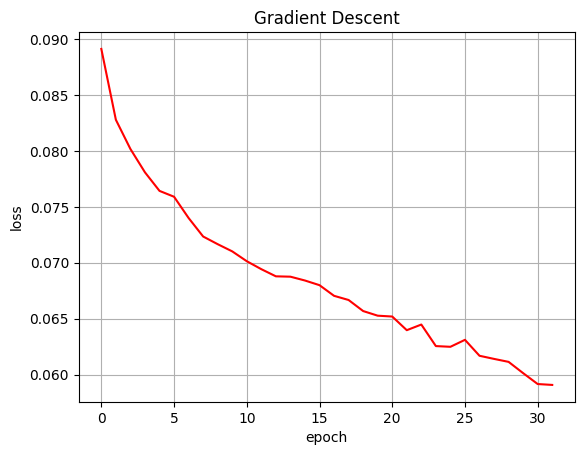

<Figure size 640x480 with 0 Axes>

In [7]:
train_loader = ds.get_loader(dataset=train_dataset, batch_size=BATCH_SIZE)
test_loader = ds.get_loader(dataset=test_dataset, batch_size=1)

criterion = nn.MSELoss()
np.random.seed(seed)
model = NeuralNetwork()

loss_train = list()

start = time.perf_counter()
for epoch in range(NUM_EPOCHS):
    loss = list()
    for idx, pack in enumerate(train_loader):
        x, y = pack
        bs = x.shape[0]
        L = x.shape[1]
        x = x.reshape(bs, 1, L)
        y = y.reshape(bs, 1, 1)
        pred = model(x)
        loss.append(criterion(pred, y))
        model.backward(lr, criterion)
        if idx % 20 == 0 or idx == len(train_dataset) - 1:
            print(
                "{}/{} - The training loss at {}th epoch : {}".format(
                    idx + 1,
                    len(train_dataset) // BATCH_SIZE,
                    epoch + 1,
                    np.array(loss).mean(),
                ),
            )
        if idx >= int(len(train_dataset) / BATCH_SIZE) - 1:
            break

    loss_train.append(np.array(loss).mean())

    if np.array(loss_train).mean() < 0.01:
        break
    print("-----------------------------------------------------------")
end = time.perf_counter()

print(f"Training finished in {epoch + 1} epochs and {end - start:0.4f} seconds")

plt.title("Gradient Descent")
plt.plot(loss_train, color = 'r')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.show()
plt.clf()

### **Testing**

In [8]:
import random


mse = list()

# Evaluation
for idx, pack in enumerate(test_loader):
     x, y = pack
     bs = x.shape[0]
     L = x.shape[1]
     x = x.reshape(bs, 1, L)
     y = y.reshape(bs, 1, 1)
     x = test_dataset.final_pred(model(x))
     y = test_dataset.final_pred(y)
     mse.append(criterion(x, y))

     if idx >= int(len(test_dataset) / BATCH_SIZE) - 1:
         break


print(f"MSE on testing: {round(np.array(mse).mean() * 100., 2)}")


# Sample
index = random.randint(0, len(test_dataset))

x, y = test_dataset[index]
x = np.array(x)
L = x.shape[0]
x = x.reshape(1, 1, L)
pred = test_dataset.final_pred(model(x))
y = test_dataset.final_pred(y)

print(f"Prediction: ${round(pred[0,0,0], 2)}")
print(f"Ground Truth: ${round(y, 2)}")

Size 330
MSE on testing: 6873781811.89
Prediction: $11163.83
Ground Truth: $12129.61


## **Newton Method**

### **Training**

Size 3300
1/206 - The training loss at 1th epoch : 0.1085253421886016
21/206 - The training loss at 1th epoch : 0.08121903246767913
41/206 - The training loss at 1th epoch : 0.0947248867925169
61/206 - The training loss at 1th epoch : 0.10170165022587777
81/206 - The training loss at 1th epoch : 0.09854367489673536
101/206 - The training loss at 1th epoch : 0.09755543521417016
121/206 - The training loss at 1th epoch : 0.09621922162596207
141/206 - The training loss at 1th epoch : 0.09781920789747364
161/206 - The training loss at 1th epoch : 0.09920453359409033
181/206 - The training loss at 1th epoch : 0.09899160998135098
201/206 - The training loss at 1th epoch : 0.09910371905211754
-----------------------------------------------------------
1/206 - The training loss at 2th epoch : 0.04684938335832274
21/206 - The training loss at 2th epoch : 0.10356147891374753
41/206 - The training loss at 2th epoch : 0.09648888369821056
61/206 - The training loss at 2th epoch : 0.0951335613160345

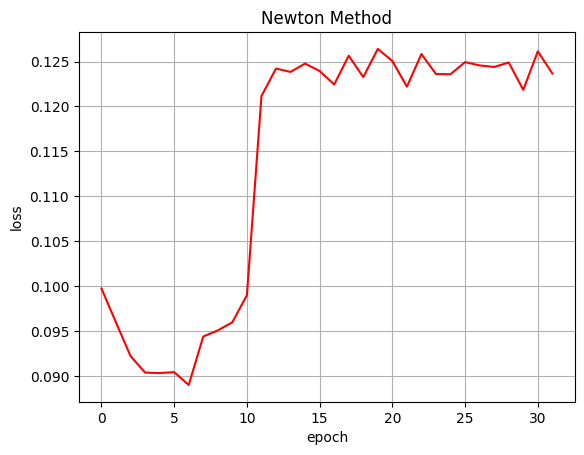

<Figure size 640x480 with 0 Axes>

In [9]:
train_loader = ds.get_loader(dataset=train_dataset, batch_size=BATCH_SIZE)
test_loader = ds.get_loader(dataset=test_dataset, batch_size=1)

criterion = nn.MSELoss()
np.random.seed(seed)
model = NeuralNetwork()

loss_train = list()

start = time.perf_counter()
for epoch in range(NUM_EPOCHS):
    loss = list()
    for idx, pack in enumerate(train_loader):
        x, y = pack
        bs = x.shape[0]
        L = x.shape[1]
        x = x.reshape(bs, 1, L)
        y = y.reshape(bs, 1, 1)
        pred = model(x)
        loss.append(criterion(pred, y))
        model.backward(lr, criterion, 'newton')
        if idx % 20 == 0 or idx == len(train_dataset) - 1:
            print(
                "{}/{} - The training loss at {}th epoch : {}".format(
                    idx + 1,
                    len(train_dataset) // BATCH_SIZE,
                    epoch + 1,
                    np.array(loss).mean(),
                ),
            )
        if idx >= int(len(train_dataset) / BATCH_SIZE) - 1:
            break

    loss_train.append(np.array(loss).mean())

    if np.array(loss_train).mean() < 0.01:
        break
    print("-----------------------------------------------------------")
end = time.perf_counter()

print(f"Training finished in {epoch + 1} epochs and {end - start:0.4f} seconds")

plt.title("Newton Method")
plt.plot(loss_train, color = 'r')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.show()
plt.clf()

### **Testing**

In [10]:
import random


mse = list()

# Evaluation
for idx, pack in enumerate(test_loader):
     x, y = pack
     bs = x.shape[0]
     L = x.shape[1]
     x = x.reshape(bs, 1, L)
     y = y.reshape(bs, 1, 1)
     x = test_dataset.final_pred(model(x))
     y = test_dataset.final_pred(y)
     mse.append(criterion(x, y))

     if idx >= int(len(test_dataset) / BATCH_SIZE) - 1:
         break


print(f"MSE on testing: {round(np.array(mse).mean() * 100., 2)}")


# Sample
index = random.randint(0, len(test_dataset))

x, y = test_dataset[index]
x = np.array(x)
L = x.shape[0]
x = x.reshape(1, 1, L)
pred = test_dataset.final_pred(model(x))
y = test_dataset.final_pred(y)

print(f"Prediction: ${round(pred[0,0,0], 2)}")
print(f"Ground Truth: ${round(y, 2)}")

Size 330
MSE on testing: 31591527570.35
Prediction: $2038.64
Ground Truth: $2264.72
